**What I want to do: **First submission gave me a log loss of 0.27459 . This is of course ridiculous, but its ok because the model was trained on the sample data. How can I check the validity of my predictions? Simples. By manually seeing whether the predictions are shit or not. Also, confusion matrices help. :)

### Admin stuff

In [1]:
%matplotlib inline

#### Define paths for training, test and validation sets

In [2]:
data_dir = "data/data_kaggle_dogscats/"
train_path = "data/data_kaggle_dogscats/train/"
test_path = "data/data_kaggle_dogscats/test/"
validation_path = "data/data_kaggle_dogscats/valid/"
sample_train_path = "data/data_kaggle_dogscats/sample/train/"
sample_validation_path = "data/data_kaggle_dogscats/sample/valid/"
results_path = "data/data_kaggle_dogscats/results/"

In [3]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from datetime import datetime
import re
from keras.preprocessing import image

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Jeremy has created a "utils.py" file with a whole host of convenience utility functions. I need to familiarise this in greater detail, especially the "plots" function. But lets simply use this for now.

In [4]:
import utils; reload(utils)
from utils import plots
from utils import save_array, load_array, plot_confusion_matrix, permutation

In [5]:
# import
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [6]:
# instantiate
vgg = Vgg16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


## Step 12: Load model trained from sample training set

Excellent points by Jeremy here. As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [7]:
vgg.model.load_weights(results_path+'sampletraining.h5')

## Step 13: Test it against the validation set to plot confusion matrix

In [8]:
%time val_batches, val_proba = vgg.test(validation_path, batch_size = 64)

Found 5000 images belonging to 2 classes.
CPU times: user 2min 37s, sys: 28.4 s, total: 3min 5s
Wall time: 2min 3s


In [9]:
filenames = val_batches.filenames
true_labels = val_batches.classes

In [10]:
sorted(val_batches.class_indices)

['cat', 'dog']

In [11]:
true_labels[:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [12]:
val_proba[:5]

array([[  1.0000e+00,   9.1579e-09],
       [  1.0000e+00,   1.2091e-09],
       [  1.0000e+00,   2.4229e-09],
       [  1.0000e+00,   9.7005e-15],
       [  1.0000e+00,   1.4970e-06]], dtype=float32)

Given that cats have index 0 and dogs have index 1, my strong guess is that the first 5 images are those of cats. Let's see...

In [13]:
# check this by eye-balling the images. USE the PLOTS helper function in utils
def plots_idx(idx, titles=None):
    plots([image.load_img(validation_path+filenames[i]) for i in idx],titles=titles)

# define number of images to view in each frame
n_view = 4

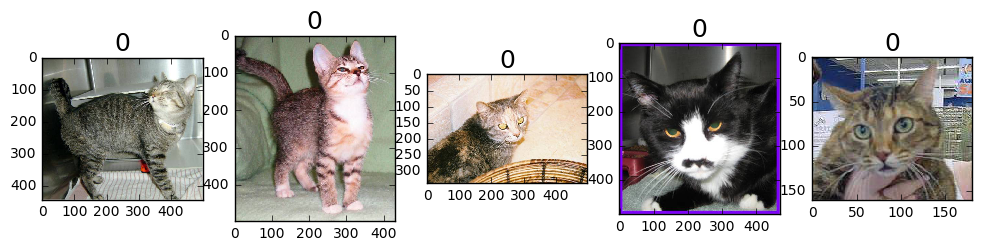

In [14]:
idx = np.arange(5)
plots_idx(idx,true_labels[idx])

Looks like the probabilities of cats and dogs dont add up to 1 exactly. Lets check that too...

In [15]:
overall = val_proba[:,0]+val_proba[:,1]

In [16]:
overall[np.where(overall>1)]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

So this means that the number by which it is greater than 1 is so small that it isnt distinguishable. This means that I can do probability of dog = (1 - probability of cat)

In [17]:
val_proba[:,1][:5]

array([  9.1579e-09,   1.2091e-09,   2.4229e-09,   9.7005e-15,   1.4970e-06], dtype=float32)

In [18]:
predicted_proba = val_proba[:,1]
predicted_labels = np.round(predicted_proba)

In [19]:
# check the validity of the predictions using confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels,predicted_labels)

In [20]:
cm

array([[2435,   84],
       [ 249, 2232]])

[[2435   84]
 [ 249 2232]]


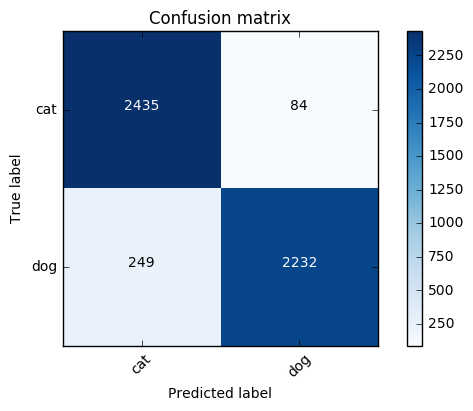

In [21]:
# import plot_confusion_matrix function from utils
plot_confusion_matrix(cm,sorted(val_batches.class_indices))

## Step 14: Plot arbitrary images and actually SEE how the model has performed

### Plot 4 arbitrary (true) dogs that were correctly predicted as dogs

In [22]:
true_dogs_pred_dogs = np.where((true_labels == predicted_labels) & (true_labels == 1))[0]
true_dogs_pred_dogs.shape

(2232,)

In [23]:
idx = permutation(true_dogs_pred_dogs)[:n_view]
idx

array([3357, 3188, 2800, 4947])

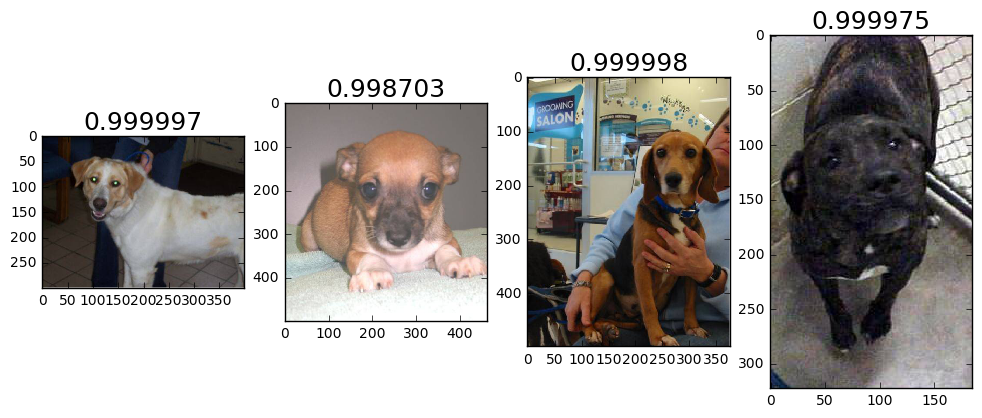

In [24]:
plots_idx(idx,predicted_proba[idx])

### Plot 4 arbitrary (true) dogs that were incorrectly predicted as cats

In [25]:
true_dogs_pred_cats = np.where((true_labels != predicted_labels) & (true_labels == 1))[0]
true_dogs_pred_cats.shape

(249,)

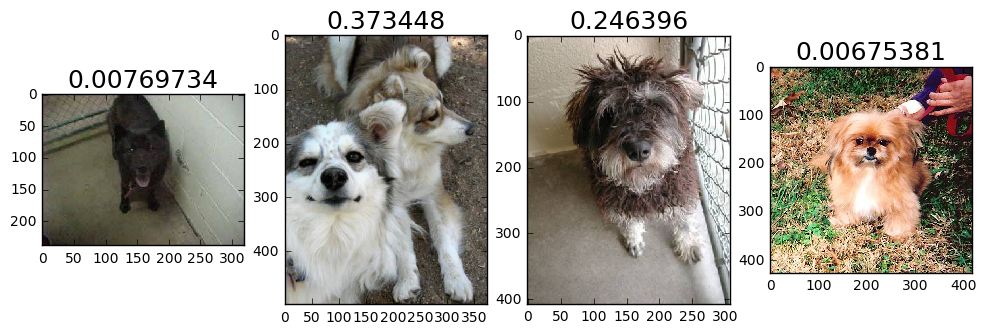

In [26]:
idx = permutation(true_dogs_pred_cats)[:4]
plots_idx(idx,predicted_proba[idx])

Some of these are quite obvious. These are screwed up definitely because they are trained on sample training set. The model is pretty terrible haha!

### Plot 4 arbitrary (true) cats that were incorrectly predicted as dogs

In [27]:
true_cats_pred_dogs = np.where((true_labels != predicted_labels) & (true_labels == 0))[0]
true_cats_pred_dogs.shape

(84,)

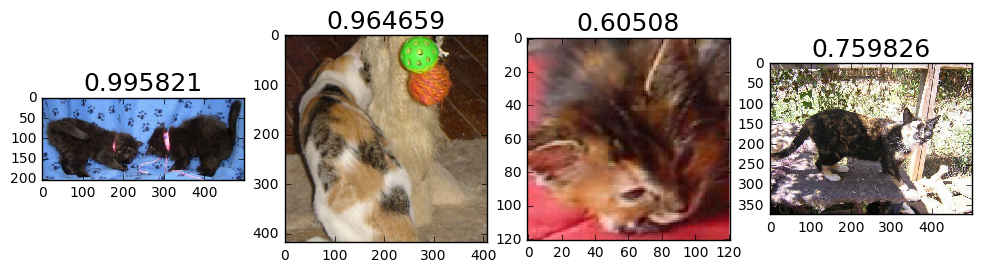

In [28]:
idx = permutation(true_cats_pred_dogs)[:4]
plots_idx(idx,predicted_proba[idx])

This is actually confusing! Based on the confusion matrix and the actual images, is it safe to say that its easier to recognise cats than dogs? :)

### Plot 4 arbitrary (true) cats that were correctly predicted as cats

In [29]:
true_cats_pred_cats = np.where((true_labels == predicted_labels) & (true_labels == 0))[0]
true_cats_pred_cats.shape

(2435,)

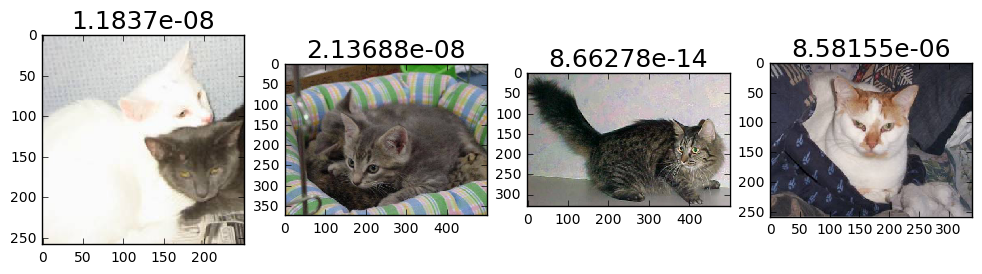

In [30]:
idx = permutation(true_cats_pred_cats)[:4]
plots_idx(idx,predicted_proba[idx])